In [33]:
# -
#
# SPDX-FileCopyrightText: Copyright (c) 2024 Pietro Carlo Boldini, Rene Pecnik and the CUBENS contributors. All rights reserved.
# SPDX-License-Identifier: MIT
#
# -

import math as m
import cmath as cm
import numpy as np
from numpy import linalg as npla

from scipy.sparse.linalg import spsolve
from scipy.sparse        import diags, hstack, vstack
from scipy.integrate     import solve_bvp
from scipy               import interpolate as intp

from functools import partial

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rcParams['figure.figsize']   = [8,6]
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family']      = 'STIXGeneral'

rcParams.update({'xtick.major.size': 6,  'xtick.minor.size': 4, 
                 'ytick.major.size': 6,  'ytick.minor.size': 4, 
                 'xtick.major.width': 1, 'xtick.minor.width': 1, 
                 'ytick.major.width': 1, 'ytick.minor.width': 1, 
                 'xtick.direction': 'out', 'ytick.direction': 'out',
                 'xtick.top': True, 'ytick.right': True, 
                 'font.size': 14})

# Compressible self-similar solution for BLs

$$\frac{d}{d\eta}\left( C\frac{d^2f}{d\eta^2}\right) + f\frac{d^2f}{d\eta^2}=0$$
$$\frac{d}{d\eta}\left( \frac{C}{Pr}\frac{d g}{d\eta}\right) + f\frac{d g}{d\eta} + C \frac{u^2_\infty}{h_\infty}\left( \frac{d^2 f}{d\eta^2}\right)^2=0$$
with
$$ \frac{df}{d\eta} = \frac{u}{u_\infty}, \quad g = \frac{h}{h_\infty}$$
and
$$C=\frac{\rho\mu}{\rho_\infty \mu_\infty}, \quad Pr=\frac{\mu c_p}{k}, \quad Ec=\frac{u^2_\infty}{c_{p,\infty}T_\infty}$$

# Boundary layer scaling

Local Reynolds number:
$$Re_{\delta} = \frac{\rho_{\infty} U_{\infty} \delta}{\mu_{\infty}} = \sqrt{Re_{x}} = \sqrt{\frac{\rho_{\infty} U_{\infty} x}{\mu_{\infty}}}$$

Reynolds number in the DNS:
$$Re_{\delta_{99}} = Re_{\delta} \delta/\delta_{99} $$

Wall-normal velocity:
$$ v Re_{\delta}= \left(\frac{u \eta}{\sqrt{4.0}} - \frac{f}{\rho\sqrt{2}}\right) $$

# Boundary-layer solver

### first the definition of the functions
### to calculate, go to the last section

In [34]:
def cBL_RHS(y, f, f_rh, f_mu, param, Ec, visc):
    [Ec_inf, T_inf, Pr_inf, u_inf2h_inf]= param()
    rh = f_rh(f[3])
    mu = f_mu(f[3],visc)
    C1 = rh*mu
    RHS = np.vstack(( f[1],                                            # f[0] = F0
                      f[2]/C1,                                         # f[1] = F1 = U
                     -f[0]*f[2]/C1,                                    # f[2] = F2
                      f[4]*Pr_inf/C1,                                  # f[3] = G0 = H
                     -f[0]*f[4]*Pr_inf/C1-u_inf2h_inf/C1*f[2]**2,      # f[4] = G1
                      np.sqrt(2.0)/rh))                                # f[5] = eta
    return RHS

def cBL_BC(f0,finf, BC_wall):
    if BC_wall == None:
        bc_res_G0 = f0[4]          # zero enthalpy gradient at the wall
    else:
        bc_res_G0 = f0[3]-BC_wall  # set enthalpy at the wall
        
    BC_res = np.array([ f0[0],
                        f0[1],
                        bc_res_G0,
                        f0[5],
                        finf[1]-1,
                        finf[3]-1 ])
    return BC_res

def solveSelfSimilar(f_rh, f_mu, param, Ec, visc, BC_wall, 
                     eta=None, f=None, verbose=2, max_nodes=20000, tol=1e-30, bc_tol=1e-20): # change "verbose" for comments on iteration procedure
    # adapt max_nodes if max residual still too high
    
    # allocate eta and f and set initial condition for f
    if np.all(eta) == None and np.all(f) == None:
        N    = 5000  # adapt if needed
        ymax = 10 # adapt if needed
        yi   = 3    # adapt if needed
        a    = ymax * yi / (ymax - 2.0 * yi)
        b    = 1 + 2.0 * a / ymax
        z    = -np.cos(np.linspace(0, np.pi, N))
        eta  = np.zeros(N)
        for ii in range(N):
            eta[ii] = a * (1 + z[ii]) / (b - z[ii])
        f    = np.zeros((6,eta.size))
        f[1] = np.sqrt(eta/eta[-1])
        f[3] = 0.5 * (1 - eta / eta[-1])
        if BC_wall == None:
            f[3] = 1.0           
        else:
            f[3] = BC_wall + (1 - BC_wall) * (eta / eta[-1])
        f[4] = 0.0
        f[5] = eta[-1]

    # solve bvp 
    res = solve_bvp(fun = lambda y,f: cBL_RHS(y,f, f_rh, f_mu, param, Ec, visc), 
                    bc  = lambda f0, finf: cBL_BC(f0, finf, BC_wall=BC_wall), 
                    x = eta, y = f, 
                    verbose=verbose, max_nodes=max_nodes, tol=tol, bc_tol=bc_tol)
    return res.sol(eta), eta

# Main classes for BL calculation

In [38]:
class BL():
    def solveBL(self, f_rh, f_mu, param, Ec, visc, Tw_Tinf, eta=None, f=None, tol=1.0e-13):
        
        self.f, self.eta = solveSelfSimilar(f_rh, f_mu, param, Ec, visc, Tw_Tinf, eta=eta, f=f, tol=tol)
        [Ec_inf, T_inf, Pr_inf, u_inf2h_inf]= param()
        self.H   = self.f[3]
        self.U   = self.f[1]
        self.d99 = self.f[5][np.where(self.U > 0.99)[0][0]]
        self.y   = self.f[5]/self.d99
        self.r   = f_rh(self.H)
        self.T   = self.f[3]
        self.mu  = f_mu(self.H,visc)

        self.V  = self.U*self.f[5]/(4.0**0.5) - self.f[0]/(f_rh(self.H)*2**0.5)

    def plot(self, ax, style = None, label = " "):
        ylim = 1.5
        ax[0].plot(self.U,self.y,linestyle=style,label=label, lw=2)
        ax[0].set_title('$u$', pad = 12)
        ax[0].set_ylabel('$y_{DNS}$')
        ax[0].legend();  ax[0].set_ylim(0, ylim)

        ax[1].plot(self.T,self.y,linestyle=style,label=label, lw=2)
        ax[1].set_title('$T$', pad = 12)
        ax[1].set_ylim(0, ylim)

        ax[2].plot(self.r,self.y,linestyle=style,label=label, lw=2)
        ax[2].set_title(r'$\rho$', pad = 12)
        ax[2].set_ylim(0, ylim)

        ax[3].plot(self.V,self.y,linestyle=style,label=label, lw=2)
        ax[3].set_title(r'$v \times Re_{\delta}$', pad = 12)
        ax[3].set_ylim(0, ylim)
        
    def extendProfileToLargerYforDNS(self, ymax=None):
        yextend = np.arange(2*self.y[-1]-self.y[-2], ymax, 1e-3)
        self.y_DNS = np.concatenate((self.y, yextend))
        self.r_DNS = np.concatenate((self.r, self.r[-1]*np.ones(yextend.size)))
        self.u_DNS = np.concatenate((self.U, self.U[-1]*np.ones(yextend.size)))
        self.v_DNS = np.concatenate((self.V, self.V[-1]*np.ones(yextend.size)))
        
    def writeToFile(self):
        self.y_DNS[0] = 0.0
        self.y_DNS.tofile('inputDNS/prof_x.bin')
        self.r_DNS.tofile('inputDNS/prof_r.bin')
        self.u_DNS.tofile('inputDNS/prof_w.bin')
        self.v_DNS.tofile('inputDNS/prof_u.bin')
        file = open("inputDNS/initBL_params.h", "w")
        file.write("!------------ use equation of state ------------------ \n")
        file.write('USE_EOS  = "IG" \n')
        file.write("!------------ set non-dimensional free-stream values for computation ------------------ \n")
        file.write("delta99   = %.10f \n" % self.d99)
        file.write("Pra   = %.10f \n" % self.Pr)
        file.write("Ec   = %.10e \n" % self.Ec)
        file.write("Ma   = %.10e \n" % self.Ma)
        file.write("Pref   = %.6f \n" % self.Rg)
        file.write("ig_gam   = %.6f \n" % self.gam)
        file.write("eos_Rgas   = %.6f \n" % self.Rg)
        file.write("eos_dof   = %.6f \n" % self.dof)
        file.write("! ------------ set wall BC for computation ------------------ \n")
        file.write('wall_bc  = "%s" \n' % self.wall_bc)
        file.write("Twall_bot   = %.6f \n" % self.Twall)
        file.write("! ----------- set viscosity and conductivity ---------------- \n")
        file.write('USE_VISC  = "%s" \n' % self.visc_bc)
        if self.visc_bc == 'Sutherland':
            file.write("Smuref   = %.6f \n" % self.Smuref)
            file.write("Tinf   = %.6f \n" % self.T_inf)
        file.close()
        
    def showParameters(self):
        
        print("\nDNS parameters:\n")
        print("USE_EOS = IG ")
        print("delta99 = ", self.d99)
        print("Pra = ", self.Pr)
        print("Ec = ", self.Ec)
        print("Ma = ", self.Ma)
        print("eos_Rgas = ", self.Rg)
        print("Pref = ", self.Rg)
        print('USE_VISC  = ', self.visc_bc)
        print('wall_bc  = ', self.wall_bc)
        
        print('\nDNS initial conditions are saved in ../inputDNS/')
        print('DNS parameters are saved in ../inputDNS/')

In [39]:
class BL_IG(BL):
    def __init__(self, Ec = None, Pr = None, visc = None, T_inf =None, gam = None, Tw_Tinf = None, eta=None, f=None):   
        self.Ec = Ec       
        self.Ma = (Ec/(gam-1.0))**0.5
        self.Pr = Pr
        self.T_inf = T_inf
        self.gam = gam
        self.Rg = 1/self.Ma**2/self.gam
        self.dof = 9
        if Tw_Tinf == None:
            self.wall_bc = 'adiab'
            self.Twall = -1.0
        else:
            self.wall_bc = 'isoth'
            self.Twall = Tw_Tinf
        if visc == 'PowerLaw':
            self.expMu = 0.75
            self.visc_bc = 'PowerLaw'
        elif visc == 'Sutherland':
            self.Smuref = 111
            self.visc_bc = 'Sutherland'
        elif visc == 'Constant':
            self.visc_bc = 'Constant'
        # save free-stream parameters in one
        self.param()
            
        self.solveBL(self.f_rh, self.f_mu, self.param, Ec, visc, Tw_Tinf, eta=eta, f=f)
        
    def param(self):
        Ec_inf = self.Ec
        T_inf = self.T_inf
        Ma_inf = self.Ma
        Pr_inf = self.Pr
        gam_inf = self.gam
        u_inf2h_inf = (gam_inf - 1)*Ma_inf**2
        return Ec_inf, T_inf, Pr_inf, u_inf2h_inf

    def f_rh(self, T):
        return 1.0/np.maximum(T,1.0e-6)

    def f_mu(self, T, visc):
        if visc == 'PowerLaw':
            return np.maximum(T,1.0e-6)**self.expMu
        elif visc == 'Sutherland':
            S = self.Smuref/self.T_inf
            return (1.0+S)*np.maximum(T,1.0e-6)**1.5/(np.maximum(T,1.0e-6)+S) 
        elif visc == 'Constant':
            return 1.0

    def f_Pr(self, T):
        return self.Pr
    
    def f_T(self, T):
        return T

#  Solve boundary layer with ideal gas

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          3.94e-03       2.92e-18         5000           9998      
       2          7.00e-10       1.74e-29         14998         (14701)    
Number of nodes is exceeded after iteration 2. 
Maximum relative residual: 7.00e-10 
Maximum boundary residual: 1.74e-29

DNS parameters:

USE_EOS = IG 
delta99 =  4.92801509185823
Pra =  0.75
Ec =  0.016
Ma =  0.2
eos_Rgas =  17.857142857142854
Pref =  17.857142857142854
USE_VISC  =  Sutherland
wall_bc  =  adiab

DNS initial conditions are saved in ../inputDNS/
DNS parameters are saved in ../inputDNS/


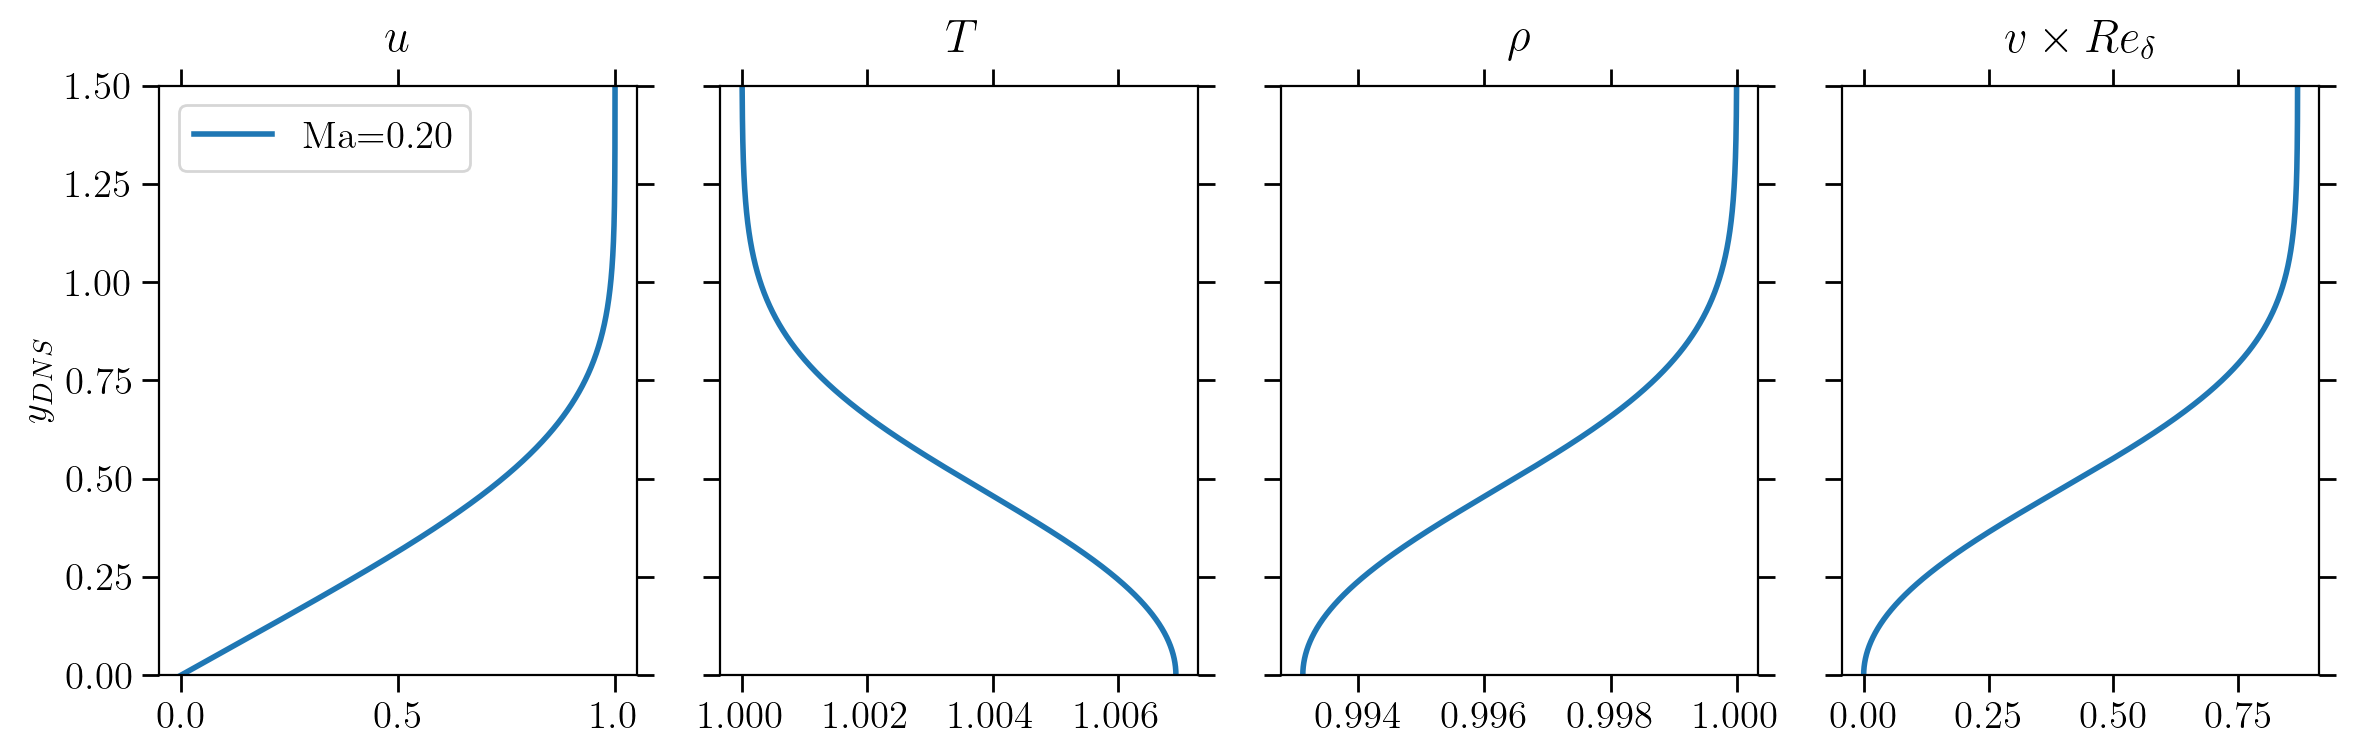

In [43]:
# Input parameters of BL_IG:
# 1) Free-stream Eckert number (Mach number will be calculated)
# 2) Free-stream Prandtl number
# 3) Viscosity law: 'PowerLaw', 'Sutherland', or 'Constant'
# 4) Reference temperature for Sutherland
# 5) Ratio of specific heat
# 6) Wall boundary condition: Tw_Tinf='None' for adiabatic or Tw_Tinf (Tw/Tinf) = ... for isothermal

ig = BL_IG(Ec=0.016, Pr=0.75, visc='Sutherland', T_inf=300, gam=1.4, Tw_Tinf=None)
ig.extendProfileToLargerYforDNS(ymax=40)
ig.writeToFile()
ig.showParameters()

fig, ax = plt.subplots(1,4, figsize=(12,4), sharey=True)
ig.plot(ax,label='Ma=%.2f'%ig.Ma)
plt.tight_layout()